In [40]:
from stable_baselines3.ppo import RNDPPO
from stable_baselines3.common.policies import RNDActorCriticPolicy
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import torch as th

def make_env(n_envs: int = 1):
    def _make_env():
        env = gym.make("MountainCarContinuous", render_mode="rgb_array") 
        env = Monitor(env)
        return env

    env = DummyVecEnv([_make_env for _ in range(n_envs)])
    return env

model_path = 'output/checkpoints/MountainCarContinuous_500000_steps.zip'

model = RNDPPO.load(model_path)

# model = RNDPPO(
#     policy=RNDActorCriticPolicy,
#     env=make_env(),
#     policy_kwargs={
#     'share_features_extractor': True,
#     'normalize_images': True,
#     'ortho_init': True,
#     'rnd_feature_dim': 32,
# },
# )

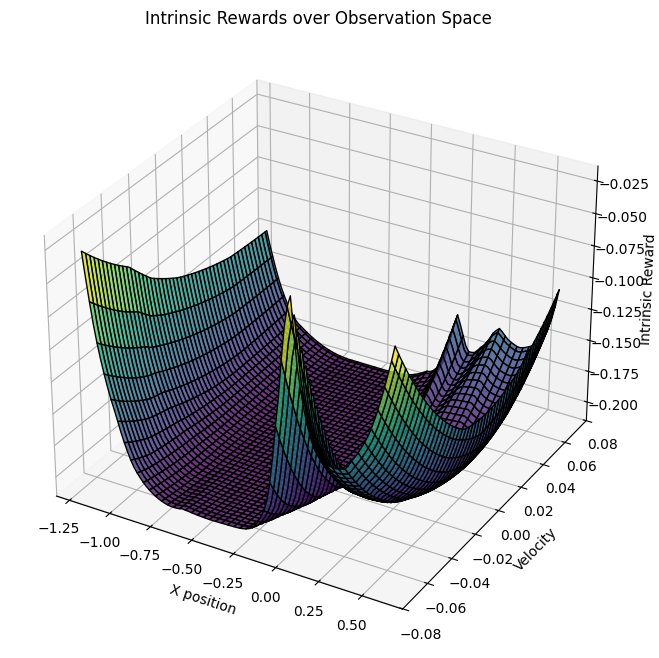

In [41]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Extract observation space bounds
obs_low = np.array([-1.2, -0.07])
obs_high = np.array([0.6, 0.07])

# Generate a grid of observations
x = np.linspace(obs_low[0], obs_high[0], 100)  # 100 points along the first dimension
y = np.linspace(obs_low[1], obs_high[1], 100)  # 100 points along the second dimension
X, Y = np.meshgrid(x, y)

# Flatten the grid for computation
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Compute intrinsic rewards for all points in the grid
with th.no_grad():  # Disable gradients for efficiency
    obs_tensor = th.tensor(grid, dtype=th.float32).cuda()
    intrinsic_rewards = model.policy.compute_intrinsic_reward(obs_tensor).cpu().numpy()

# Reshape the intrinsic rewards to match the grid
intrinsic_rewards = intrinsic_rewards.reshape(X.shape)

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
ax.plot_surface(X, Y, intrinsic_rewards, cmap='viridis', edgecolor='k', alpha=0.8)

# Add labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Intrinsic Reward')
ax.set_title('Intrinsic Rewards over Observation Space')

plt.show()


In [57]:
import ale_py
import gymnasium as gym
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from gymnasium.wrappers.frame_stack import FrameStack
from stable_baselines3.common.atari_wrappers import AtariWrapper

class CustomObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Update the observation space to reflect the new shape
        obs_shape = self.observation_space.shape  # Original shape
        new_shape = (obs_shape[0] * obs_shape[3], obs_shape[1], obs_shape[2])
        self.observation_space = gym.spaces.Box(
            low=self.observation_space.low.min(),
            high=self.observation_space.high.max(),
            shape=new_shape,
            dtype=self.observation_space.dtype
        )

    def observation(self, observation):
        # Reorder dimensions from (4, 84, 84, 1) to (4, 1, 84, 84)
        reordered_obs = np.transpose(observation, (0, 3, 1, 2))
        # Merge the first two dimensions to get shape (4, 84, 84)
        merged_obs = reordered_obs.reshape(-1, *reordered_obs.shape[2:])
        return merged_obs

env = gym.make("ALE/MontezumaRevenge", render_mode="rgb_array") 
env = AtariWrapper(env)
env = FrameStack(env, num_stack=4)
env = CustomObservationWrapper(env)


/home/eyu/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `ALE/MontezumaRevenge-v5` instead of the unversioned environment `ALE/MontezumaRevenge`.
  logger.warn(


In [59]:
(1, *[1,2])

(1, 1, 2)